In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [29]:
# Экспрессия в тканях человека - 9 датасетов

dfs_human = []

path = '/home/sergey/biohack/datasets_human_corrected/'
for i in range(9):
    dfs_human.append(pd.read_csv(path + 'dataset_' + str(i+1) + '.csv', sep = '\t', index_col = 0).set_index('Tissue'))
    

# Экспрессия в тканях мыши - 20 датасетов

dfs_mouse = []

path = '/home/sergey/biohack/datasets_mouse_corrected/'
for i in range(20):
    dfs_mouse.append(pd.read_csv(path + 'dataset_' + str(i+1) + '.csv', sep = '\t', index_col = 0).set_index('Tissue'))
    

# База ортологов для человека - мыши

orthologs = pd.read_csv('/home/sergey/biohack/gateway.txt', sep = '\t', names = ['h', 'm', 'x', 'y'])

In [17]:
hum2mouse = {}
mouse2human = {}

for i in range(orthologs.shape[0]):
    
    if orthologs.iloc[i, 0] not in hum2mouse.keys():
        hum2mouse[orthologs.iloc[i, 0]] = [orthologs.iloc[i, 1]]
    else:
        hum2mouse[orthologs.iloc[i, 0]].append(orthologs.iloc[i, 1])
        
    if orthologs.iloc[i, 1] not in mouse2human.keys():
        mouse2human[orthologs.iloc[i, 1]] = [orthologs.iloc[i, 0]]
    else:
        mouse2human[orthologs.iloc[i, 1]].append(orthologs.iloc[i, 0])

In [18]:
# Получить список значений экспрессий для конкретного гена в конкретной ткани

def get_expr_list(expressions, gene, tissue):
    
    expr_list = []
    for i in range(len(expressions)):
        try:
            # expr_list.append(list(expressions[i].T[tissue].loc[gene]))
            expr_list += list(expressions[i].T[tissue].loc[gene])
        except Exception:
            continue
    
    return expr_list


# Получить ортологов для ген_человека-> список генов мыши (Или наоборот)

def find_orthologs(gene_id):
    
    if gene_id in hum2mouse.keys():
        return hum2mouse[gene_id]
    elif gene_id in mouse2human.keys():
        return mouse2human[gene_id]
    else:
        return 'NO GENE FOUND'

In [24]:
def swap_id_or_name(target, path='biohack/Homo_sapiens_mapping.csv'):
    db_frame = pd.read_csv(path, sep=',')
    try:
        assert any(db_frame.label == target)
        return db_frame[(db_frame['label'] == target)]['gene_symbol'].values[0]
    except AssertionError:
        try:
            return db_frame[(db_frame['gene_symbol'] == target)]['label'].values[0]
        except IndexError:
            return 'NO GENE FOUND'
    except IndexError:
        return 'NO GENE FOUND'
    

def align_by_id(target, path='biohack/Homo_sapiens_mapping.csv'):
    db_frame = pd.read_csv(path, sep=',')
    try:
        assert any(db_frame.label == target)
        return target
    except AssertionError:
        try:
            return db_frame[(db_frame['gene_symbol'] == target)]['label'].values[0]
        except IndexError:
            return 'NO GENE FOUND'
    except IndexError:
        return 'NO GENE FOUND'

In [43]:
# Интересующие гены

gene_human = ['FOS', 'SLC29A1', 'DLAT', 'IL18', 'OXTR', 'HTR2A', 'CACNA1I', 'GRIN2A', 'PTGDR', 'OXT', 'MRGPRX2']
gene_mouse = ['Fos', 'Snap25', 'Slc29a1', 'Dlat', 'Oxt', 'Il18', 'Cacna1i', 'Grin2a', 'Htr2a', 'Oxtr', 'Ptgdr']

tissue = 'Immune and Lymphatic System'

In [44]:
# Получим значения экспрессий для человека и мыши

expr_human = {}
for gene in gene_human:
    expr_human[gene] = get_expr_list(dfs_human, gene, tissue)

expr_mouse = {}
for gene in gene_mouse:
    expr_mouse[gene] = get_expr_list(dfs_mouse, gene, tissue)

In [82]:
# Получим значения экспрессии для ортологов человека

expr_hum_orth = {}
gene_corresp = {}
for gene in gene_human:
    
    orth_genes_id = find_orthologs(align_by_id(gene))
    
    # Вернем ортологичные гены (в мышах!) к обычным названиям
    orth_genes = [swap_id_or_name(orth_id, path='biohack/Mus_musculus_mapping.csv') for orth_id in orth_genes_id]
    # Сохраним для каждого гена его ортологов
    gene_corresp[gene] = orth_genes
    
    # orth_genes = list(map(swap_id_or_name(path='biohack/Mus_musculus_mapping.csv'), orth_genes_id))
    
    # Для каждого ортологичного гена добавим значение экспрессии
    for orth_gene in orth_genes:
        expr_hum_orth[orth_gene] = get_expr_list(dfs_mouse, orth_gene, tissue)

In [74]:
# Получим значения экспрессии для ортологов мыши

expr_mou_orth = {}
gene_corresp = {}
for gene in gene_mouse:
    orth_genes_id = find_orthologs(align_by_id(gene, path='biohack/Mus_musculus_mapping.csv'))
    
    # Вернем ортологичные гены (в человеке!) к обычным названиям
    orth_genes = [swap_id_or_name(orth_id, path='biohack/Homo_sapiens_mapping.csv') for orth_id in orth_genes_id]
    # Сохраним для каждого гена его ортологов
    gene_corresp[gene] = orth_genes
    
    # orth_genes = list(map(swap_id_or_name(path='biohack/Mus_musculus_mapping.csv'), orth_genes_id))
    
    # Для каждого ортологичного гена добавим значение экспрессии
    for orth_gene in orth_genes:
        expr_mou_orth[orth_gene] = get_expr_list(dfs_human, orth_gene, tissue)

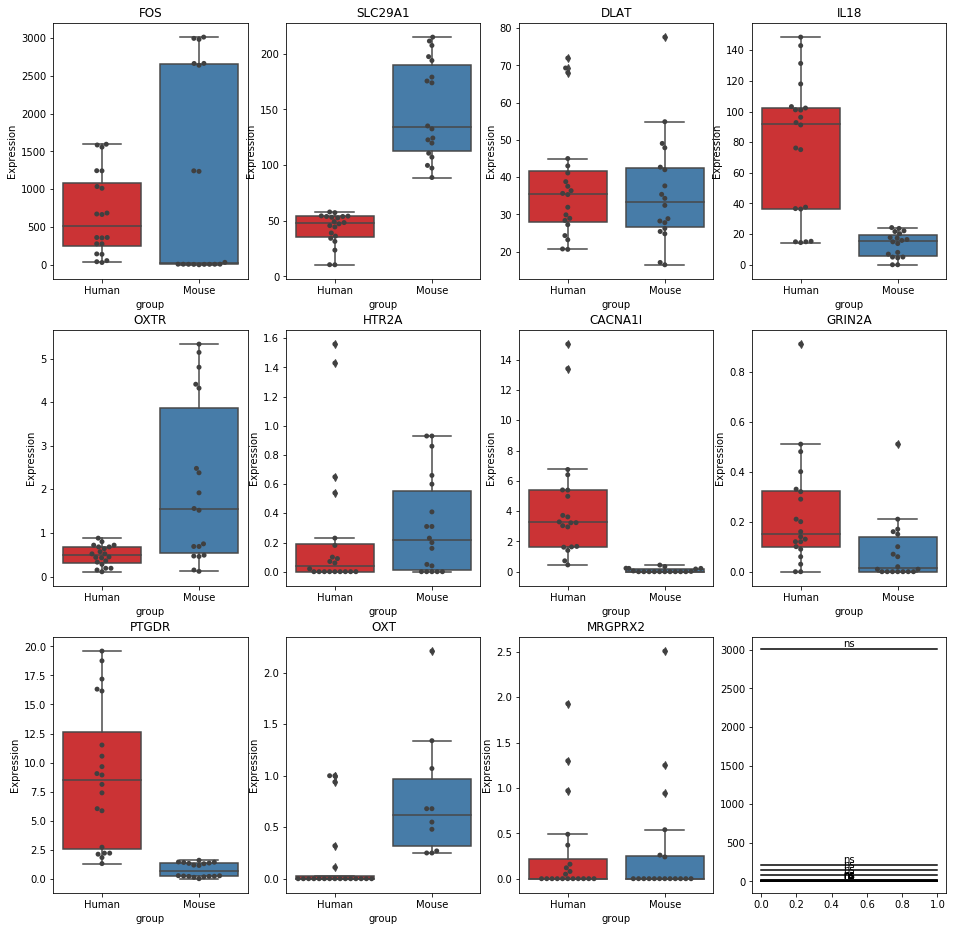

In [179]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 16))

for idx, feat in  enumerate(list(expr_human.keys())):
    
    # gene_name = list(expr_human.keys())[idx]
    gene_orth_name = gene_corresp[feat][0]
    a = pd.DataFrame({ 'group' : np.repeat('Human',len(expr_human[feat])), 'Expression': expr_human[feat] })
    b = pd.DataFrame({ 'group' : np.repeat('Mouse',len(expr_hum_orth[gene_orth_name])), 'Expression': expr_hum_orth[gene_orth_name] })
    df=a.append(b)
    
    sns.boxplot(x='group', y='Expression', data=df, palette="Set1", ax=axes[int(idx / 4), idx % 4])
    sns.swarmplot(x="group", y="Expression", data=df, color=".25", ax=axes[int(idx / 4), idx % 4])
    
    # axes[int(idx / 4), idx % 4].legend()
    axes[int(idx / 4), idx % 4].set_title(feat)
    # axes[int(idx / 4), idx % 4].set_xlabel('Churn')
    # axes[int(idx / 4), idx % 4].set_ylabel(feat);
    
    
fig.savefig('boxplot.png')

In [182]:
for idx, feat in  enumerate(list(expr_human.keys())):
    
    # gene_name = list(expr_human.keys())[idx]
    gene_orth_name = gene_corresp[feat][0]
    a = pd.DataFrame({ 'group' : np.repeat('Human',len(expr_human[feat])), 'Expression': expr_human[feat] })
    b = pd.DataFrame({ 'group' : np.repeat('Mouse',len(expr_hum_orth[gene_orth_name])), 'Expression': expr_hum_orth[gene_orth_name] })
    S, p = stats.mannwhitneyu(a.Expression, b.Expression)
    
    if p < 0.05 / len(expr_human):
        print('{}: p-value = {}'.format(feat, p))

SLC29A1: p-value = 7.699217238134656e-08
IL18: p-value = 1.5482315961250194e-05
OXTR: p-value = 0.001427298957180655
CACNA1I: p-value = 5.91674211224094e-08
GRIN2A: p-value = 0.0036911338753935906
PTGDR: p-value = 1.959259987195414e-07
OXT: p-value = 0.0001915923998039453


### Посмотрим на гены нюха

In [281]:
with open('biohack/h_nux.txt') as f:
    gene_human = [line.strip() for line in f.readlines()]
    
with open('biohack/m_nux.txt') as f:
    gene_mouse = [line.strip() for line in f.readlines()]
    
tissue = 'Nervous System'

In [282]:
# Получим значения экспрессий для человека и мыши

expr_human = {}
for gene in gene_human:
    expr_human[gene] = get_expr_list(dfs_human, gene, tissue)

expr_mouse = {}
for gene in gene_mouse:
    expr_mouse[gene] = get_expr_list(dfs_mouse, gene, tissue)

In [283]:
# Получим значения экспрессии для ортологов человека

expr_hum_orth = {}
gene_corresp = {}
for gene in gene_human:
    
    orth_genes_id = find_orthologs(align_by_id(gene))
    
    # Вернем ортологичные гены (в мышах!) к обычным названиям
    orth_genes = [swap_id_or_name(orth_id, path='biohack/Mus_musculus_mapping.csv') for orth_id in orth_genes_id]
    # Сохраним для каждого гена его ортологов
    gene_corresp[gene] = orth_genes
    
    # orth_genes = list(map(swap_id_or_name(path='biohack/Mus_musculus_mapping.csv'), orth_genes_id))
    
    # Для каждого ортологичного гена добавим значение экспрессии
    for orth_gene in orth_genes:
        expr_hum_orth[orth_gene] = get_expr_list(dfs_mouse, orth_gene, tissue)

In [306]:
for key in expr_human.keys():
    
    data_hum = [np.mean(expr_human[key]) for key in expr_human.keys()]
    names_hum = [key for key in expr_human.keys()]
    
    # expr_hum_orth[gene_orth_name]
    data_mou = [np.mean(expr_hum_orth[gene_corresp[key][0]]) for key in expr_human.keys()]
    names_mou = [gene_corresp[key][0] for key in expr_human.keys()]

In [315]:
data_hum1 = [data_hum[i] for i in range(len(data_hum)) if names_mou[i] != 'NO GENE FOUND']
data_mou1 = [data_mou[i] for i in range(len(data_mou)) if names_mou[i] != 'NO GENE FOUND']

names_hum1 = [names_hum[i] for i in range(len(names_hum)) if names_mou[i] != 'NO GENE FOUND']
names_mou1 = [names_mou[i] for i in range(len(names_mou)) if names_mou[i] != 'NO GENE FOUND']

In [330]:
with open('biohack/data_hum1.txt', 'w') as f:
    f.write('\n'.join(list(map(str, data_hum1))))
    
with open('biohack/data_mou1.txt', 'w') as f:
    f.write('\n'.join(list(map(str, data_mou1))))

with open('biohack/names_hum1.txt', 'w') as f:
    f.write('\n'.join(names_hum1))

with open('biohack/names_mou1.txt', 'w') as f:
    f.write('\n'.join(names_mou1))

In [243]:
count_not_z = 0

for i in gene_corresp.keys():
    if gene_corresp[i] != 'NO GENE FOUND':
        count_not_z += 1

count_not_z + len(count_z)

514

In [196]:
# Получим значения экспрессии для ортологов мыши

expr_mou_orth = {}
gene_corresp = {}
for gene in gene_mouse:
    orth_genes_id = find_orthologs(align_by_id(gene, path='biohack/Mus_musculus_mapping.csv'))
    
    # Вернем ортологичные гены (в человеке!) к обычным названиям
    orth_genes = [swap_id_or_name(orth_id, path='biohack/Homo_sapiens_mapping.csv') for orth_id in orth_genes_id]
    # Сохраним для каждого гена его ортологов
    gene_corresp[gene] = orth_genes
    
    # orth_genes = list(map(swap_id_or_name(path='biohack/Mus_musculus_mapping.csv'), orth_genes_id))
    
    # Для каждого ортологичного гена добавим значение экспрессии
    for orth_gene in orth_genes:
        expr_mou_orth[orth_gene] = get_expr_list(dfs_human, orth_gene, tissue)

In [287]:
sig_expr_human = {}
count_z = []
с = 0

for idx, feat in  enumerate(list(expr_human.keys())):
    
    # gene_name = list(expr_human.keys())[idx]
    try:
        gene_orth_name = gene_corresp[feat][0]
    except Exception:
        continue

    a = pd.DataFrame({ 'group' : np.repeat('Human',len(expr_human[feat])), 'Expression': expr_human[feat] })
    b = pd.DataFrame({ 'group' : np.repeat('Mouse',len(expr_hum_orth[gene_orth_name])), 'Expression': expr_hum_orth[gene_orth_name] })
    
    if a.shape[0] == 0 or b.shape[0] == 0:
        count_z.append(feat)
        continue

    try:
        S, p = stats.mannwhitneyu(a.Expression, b.Expression)
    except Exception:
        continue
    
    с += 1
    if p < 0.05 / len(expr_human):
        print('{}: p-value = {}'.format(feat, p))
        sig_expr_human[feat] = expr_human[feat]

OR2W3: p-value = 2.8383467698430465e-104
DAPL1: p-value = 9.488247903757927e-17
OR2L13: p-value = 9.33864573169611e-122
OR2A7: p-value = 2.1034125930410944e-09
OR51E1: p-value = 8.985542757998449e-14
OR2T8: p-value = 6.127945183820147e-65
OR2B6: p-value = 2.521459125616024e-59
OR52N4: p-value = 2.6154651989275175e-27
OR2L2: p-value = 4.796416010174362e-27
OR7A5: p-value = 8.908975568824887e-42
OR2C1: p-value = 1.030979910658022e-37
OR2K2: p-value = 5.177676229921789e-17
OR1L8: p-value = 3.2536513579337756e-51
OR2L3: p-value = 8.260488985740203e-08
OR10AD1: p-value = 3.245005113354414e-11
OR2AG2: p-value = 7.799153634113185e-51
OR52N2: p-value = 2.168536901256435e-09
OR5K2: p-value = 1.786688573342785e-63
OR13C5: p-value = 5.142037228756146e-56
OR2AT4: p-value = 3.363338608657225e-11
OR3A1: p-value = 1.4692374219028293e-29
OR2B11: p-value = 1.67416349112954e-08
OR6N2: p-value = 1.5583989525630572e-13
OR51B4: p-value = 3.417168479099503e-47
OR13J1: p-value = 4.5358086965650376e-51
OR10Q1

IndexError: index 7 is out of bounds for axis 0 with size 7

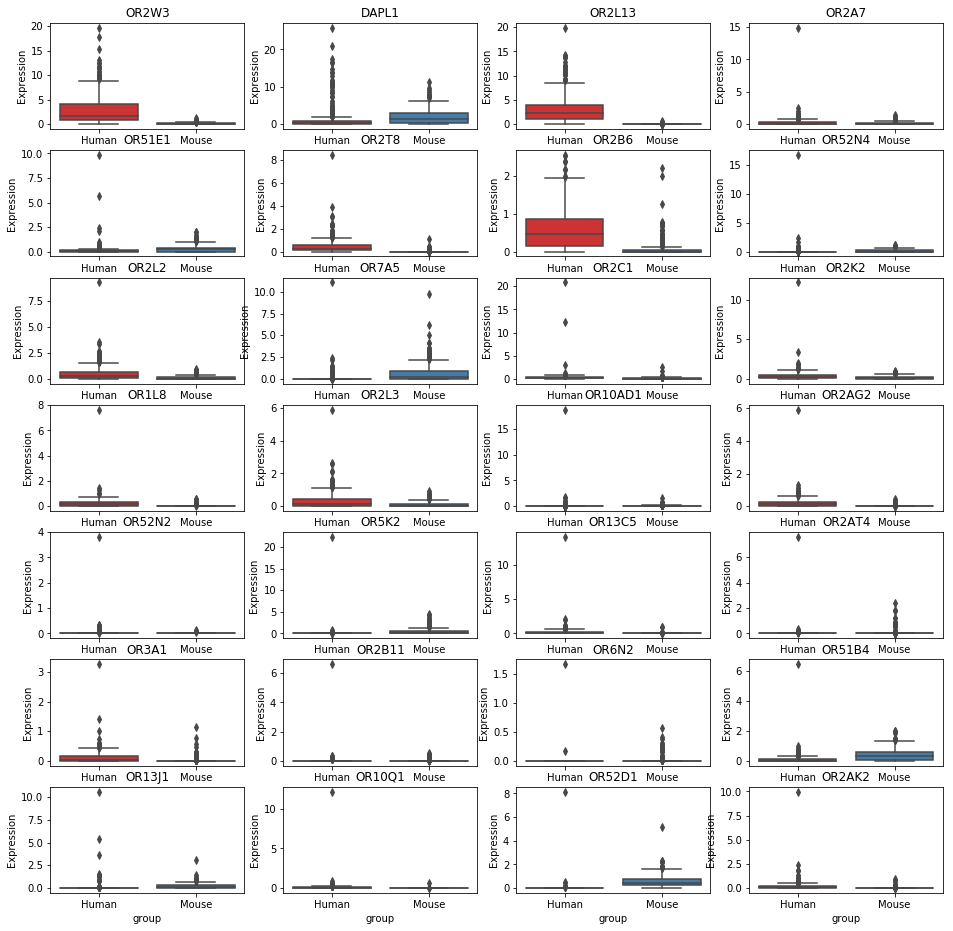

In [331]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 16))

for idx, feat in  enumerate(list(sig_expr_human.keys())):
    
    # gene_name = list(expr_human.keys())[idx]
    gene_orth_name = gene_corresp[feat][0]
    a = pd.DataFrame({ 'group' : np.repeat('Human',len(sig_expr_human[feat])), 'Expression': sig_expr_human[feat] })
    b = pd.DataFrame({ 'group' : np.repeat('Mouse',len(expr_hum_orth[gene_orth_name])), 'Expression': expr_hum_orth[gene_orth_name] })
    df=a.append(b)
    
    sns.boxplot(x='group', y='Expression', data=df, palette="Set1", ax=axes[int(idx / 4), idx % 4])
    # sns.swarmplot(x="group", y="Expression", data=df, color=".25", ax=axes[int(idx / 4), idx % 4])
    
    # axes[int(idx / 4), idx % 4].legend()
    axes[int(idx / 4), idx % 4].set_title(feat)
    # axes[int(idx / 4), idx % 4].set_xlabel('Churn')
    # axes[int(idx / 4), idx % 4].set_ylabel(feat);
    
    
fig.savefig('boxplot.png')

### Посмотрим на гены шаперонов

In [258]:
with open('biohack/h_chaperones.txt') as f:
    gene_human = [line.strip() for line in f.readlines()]
    
with open('biohack/m_chaperones.txt') as f:
    gene_mouse = [line.strip() for line in f.readlines()]
    

tissue = 'Nervous System'

In [261]:
# Получим значения экспрессий для человека и мыши в данной ткани

expr_human = {}
for gene in gene_human:
    expr_human[gene] = get_expr_list(dfs_human, gene, tissue)

expr_mouse = {}
for gene in gene_mouse:
    expr_mouse[gene] = get_expr_list(dfs_mouse, gene, tissue)

In [263]:
# Получим значения экспрессии для ортологов человека в данной ткани

expr_hum_orth = {}
gene_corresp = {}
for gene in gene_human:
    
    orth_genes_id = find_orthologs(align_by_id(gene))
    
    # Вернем ортологичные гены (в мышах!) к обычным названиям
    orth_genes = [swap_id_or_name(orth_id, path='biohack/Mus_musculus_mapping.csv') for orth_id in orth_genes_id]
    # Сохраним для каждого гена его ортологов
    gene_corresp[gene] = orth_genes
    
    # orth_genes = list(map(swap_id_or_name(path='biohack/Mus_musculus_mapping.csv'), orth_genes_id))
    
    # Для каждого ортологичного гена добавим значение экспрессии
    for orth_gene in orth_genes:
        expr_hum_orth[orth_gene] = get_expr_list(dfs_mouse, orth_gene, tissue)

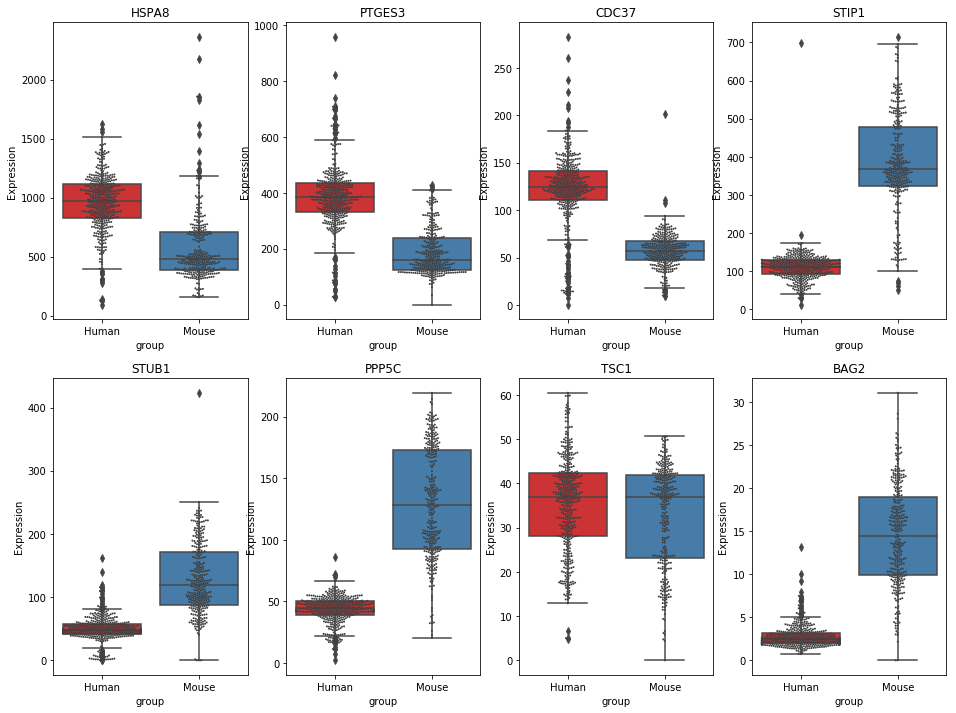

In [279]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))

for idx, feat in  enumerate(list(expr_human.keys())):
    
    # gene_name = list(expr_human.keys())[idx]
    gene_orth_name = gene_corresp[feat][0]
    a = pd.DataFrame({ 'group' : np.repeat('Human',len(expr_human[feat])), 'Expression': expr_human[feat] })
    b = pd.DataFrame({ 'group' : np.repeat('Mouse',len(expr_hum_orth[gene_orth_name])), 'Expression': expr_hum_orth[gene_orth_name] })
    df=a.append(b)
    
    sns.boxplot(x='group', y='Expression', data=df, palette="Set1", ax=axes[int(idx / 4), idx % 4])
    sns.swarmplot(x="group", y="Expression", data=df, color=".25", size = 2, ax=axes[int(idx / 4), idx % 4])
    
    # axes[int(idx / 4), idx % 4].legend()
    axes[int(idx / 4), idx % 4].set_title(feat)
    # axes[int(idx / 4), idx % 4].set_xlabel('Churn')
    # axes[int(idx / 4), idx % 4].set_ylabel(feat);
    
    
fig.savefig('boxplot.png')

In [278]:
for idx, feat in  enumerate(list(expr_human.keys())):
    
    # gene_name = list(expr_human.keys())[idx]
    gene_orth_name = gene_corresp[feat][0]
    a = pd.DataFrame({ 'group' : np.repeat('Human',len(expr_human[feat])), 'Expression': expr_human[feat] })
    b = pd.DataFrame({ 'group' : np.repeat('Mouse',len(expr_hum_orth[gene_orth_name])), 'Expression': expr_hum_orth[gene_orth_name] })
    S, p = stats.mannwhitneyu(a.Expression, b.Expression)
    
    if p < 0.05 / len(expr_human):
        print('{}: p-value = {}'.format(feat, p))

HSPA8: p-value = 4.692512115583682e-67
PTGES3: p-value = 5.051140847001321e-89
CDC37: p-value = 4.3828258695798426e-86
STIP1: p-value = 1.40378950659173e-112
STUB1: p-value = 2.4671144811166492e-98
PPP5C: p-value = 2.1662238601480954e-110
BAG2: p-value = 1.0961377779342455e-116


In [280]:
?plt.legend